In [1]:

import numpy as np
import os
os.chdir('..')
from rss import rSNAPsim
from rss import ProbeVectorFactory as pvf
from rss import PropensityFactory as pff
from rss import TranslationSolvers as tss
from rss import CodonOptimizer as copt
from rss import CodonDictionaries as cdict
from rss import SequenceManipMethods as smm
from rss import IntensityAnalyses as ia

from matplotlib import cm
import matplotlib.pyplot as plt
import time
from rss import FragmentSeperator as fss
os.chdir('trna_ssa')


importing C++ models
c++ models loaded successfully
importing C++ models
c++ models loaded successfully


## Problem setup and description

Given a protein (Human insulin receptor, 1739aa with 10xFLAG tag)

Lets compare wildtype, optimizated, and deoptimized codon sequences with the 2019 Auguilera model and the tRNA pooling model

First lets setup the solver objects and compare the sequences

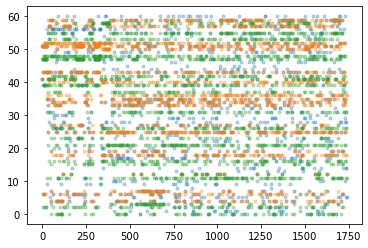

In [2]:
rsim = rSNAPsim()
rsim.open_seq_file('../gene_files/HUMINSR.gb')
poi = rsim.proteins['1'][0]  #protein object

huminsr_opt_seq = copt().optimize_ntseq(poi.nt_seq)
huminsr_deopt_seq = copt().deoptimize_ntseq(poi.nt_seq)

ktrna_id_opt = pff().get_trna_ids(huminsr_opt_seq)
ktrna_id_deopt = pff().get_trna_ids(huminsr_deopt_seq)

plt.plot(poi.ktrna_id,'.',alpha=.3)
plt.plot(ktrna_id_opt,'.',alpha=.3)
plt.plot(ktrna_id_deopt,'.',alpha=.3)



In [3]:
colors = cm.viridis(np.linspace(0,1,61))

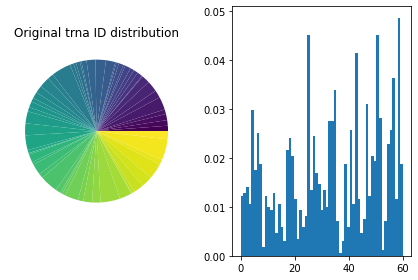

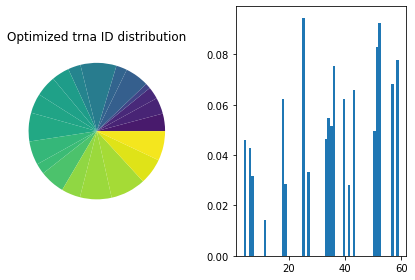

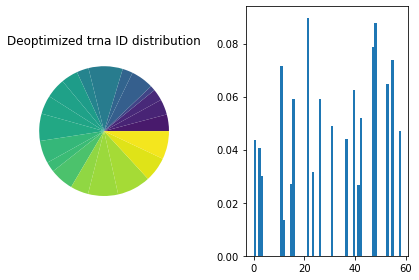

In [4]:
(tid,counts) = np.unique(poi.ktrna_id, return_counts=True)
fig,ax = plt.subplots(1,2)
ax[0].pie(counts,colors = colors)
ax[0].set_title('Original trna ID distribution')

ax[1].hist(poi.ktrna_id,density=True,bins=61)
fig.tight_layout()


(tid,counts) = np.unique(ktrna_id_opt, return_counts=True)
fig,ax = plt.subplots(1,2)
ax[0].pie(counts,colors = colors[tid])
ax[0].set_title('Optimized trna ID distribution')

ax[1].hist(ktrna_id_opt,density=True,bins=61)
fig.tight_layout()

fig,ax = plt.subplots(1,2)
ax[0].pie(counts,colors = colors[tid])
ax[0].set_title('Deoptimized trna ID distribution')





ax[1].hist(ktrna_id_deopt,density=True,bins=61)
fig.tight_layout()
pass

In [5]:
counts

array([ 72,  67,  50,  22,  98,  45, 148,  52,  73,  86,  81, 118,  98,
        44, 103,  78, 130, 145, 107, 122], dtype=int64)

In [6]:
huminsr = rsim.proteins['1'][0]  #protein object

rsim2 = rSNAPsim()
rsim2.open_seq_file('../gene_files/HUMINSR.gb')
huminsr_deopt = rsim2.proteins['1'][0]  #protein object

rsim3 = rSNAPsim()
rsim3.open_seq_file('../gene_files/HUMINSR.gb')
huminsr_opt = rsim3.proteins['1'][0]  #protein object

huminsr_opt.nt_seq = huminsr_opt_seq
huminsr_opt.aa_seq = smm('').nt2aa(huminsr_opt_seq)

huminsr_deopt.nt_seq = huminsr_deopt_seq
huminsr_deopt.aa_seq = smm('').nt2aa(huminsr_deopt_seq)


In [7]:
wt_solver = tss()  #solver class
wt_solver.protein=huminsr
wt_solver.default_conditions['burnin'] = 1000

opt_solver = tss()  #solver class
opt_solver.protein=huminsr_opt
wt_solver.default_conditions['burnin'] = 1000

deopt_solver = tss()  #solver class
deopt_solver.protein=huminsr_deopt
wt_solver.default_conditions['burnin'] = 1000

trna_inv = dict(map(reversed, cdict().trna_dict.items()))
huminsr_mean = np.mean([cdict().strGeneCopy[y] for y in [trna_inv[x] for x in huminsr.ktrna_id]])


t = np.linspace(0,2000,2001)
huminsr.ke_mu = huminsr_mean
huminsr_opt.ke_mu = huminsr_mean
huminsr_deopt.ke_mu = huminsr_mean
ssa_soln_wt = wt_solver.solve_ssa([.033] + huminsr.kelong + [10],t,n_traj=50, low_memory=False, record_stats=True)
ssa_soln_opt = opt_solver.solve_ssa([.033] + huminsr_opt.kelong + [10],t,n_traj=50)
ssa_soln_deopt = deopt_solver.solve_ssa([.033] + huminsr_deopt.kelong + [10],t,n_traj=50)

(1, 2001, 50)

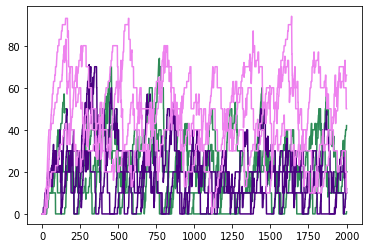

In [8]:
plt.plot(ssa_soln_wt.intensity_vec[0][:,0:3],'seagreen',alpha=1)
plt.plot(ssa_soln_opt.intensity_vec[0][:,0:3],'indigo',alpha=1)
plt.plot(ssa_soln_deopt.intensity_vec[0][:,0:3],'violet',alpha=1)
ssa_soln_wt.intensity_vec.shape

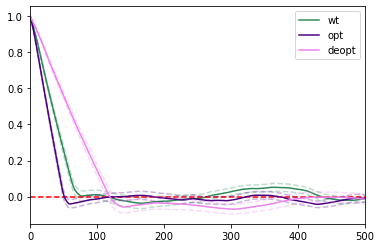

In [9]:
acov,err_acov = ia().get_autocov(ssa_soln_wt.intensity_vec[:,1000:,:],norm='global')
acc,err_acorr = ia().get_autocorr(acov)



plt.plot(np.mean(acc[0],axis=1),color='seagreen');
plt.plot(np.mean(acc[0],axis=1) - err_acorr[0],'--',color='seagreen', label='_nolegend_',alpha=.3)
plt.plot(np.mean(acc[0],axis=1)+ err_acorr[0],'--',color='seagreen', label='_nolegend_',alpha=.3)
plt.plot([0,500],[0,0],'r--', label='_nolegend_')
plt.xlim([0,500])


acov,err_acov = ia().get_autocov(ssa_soln_opt.intensity_vec[:,1000:,:],norm='global')
acc,err_acorr = ia().get_autocorr(acov)
plt.plot(np.mean(acc[0],axis=1),color='indigo');
plt.plot(np.mean(acc[0],axis=1) - err_acorr[0],'--',color='indigo', label='_nolegend_',alpha=.3)
plt.plot(np.mean(acc[0],axis=1)+ err_acorr[0],'--',color='indigo', label='_nolegend_',alpha=.3)

plt.xlim([0,500])



acov,err_acov = ia().get_autocov(ssa_soln_deopt.intensity_vec[:,1000:,:],norm='global')
acc,err_acorr = ia().get_autocorr(acov)

plt.plot(np.mean(acc[0],axis=1),color='violet');
plt.plot(np.mean(acc[0],axis=1) - err_acorr[0],'--',color='violet', label='_nolegend_',alpha=.3)
plt.plot(np.mean(acc[0],axis=1)+ err_acorr[0],'--',color='violet', label='_nolegend_',alpha=.3)

plt.xlim([0,500])

plt.legend(['wt','opt','deopt',])


In [10]:

strGeneCopy = {'TTT': 17.6, 'TCT': 15.2, 'TAT': 12.2, 'TGT': 10.6, 'TTC': 20.3,
                            'TCC': 17.7, 'TAC': 15.3, 'TGC': 12.6, 'TTA': 7.7, 'TCA': 12.2,
                            'TAA': 1.0, 'TGA': 1.6, 'TTG': 12.9, 'TCG':  4.4, 'TAG': 0.8,
                            'TGG': 13.2, 'CTT': 13.2, 'CCT': 17.5, 'CAT': 10.9, 'CGT': 4.5,
                            'CTC': 19.6, 'CCC': 19.8, 'CAC': 15.1, 'CGC': 10.4, 'CTA':  7.2,
                            'CCA': 16.9, 'CAA': 12.3, 'CGA':  6.2, 'CTG': 39.6, 'CCG':  6.9,
                            'CAG': 34.2, 'CGG': 11.4, 'ATT': 16.0, 'ACT': 13.1, 'AAT': 17.0,
                            'AGT': 12.1, 'ATC': 20.8, 'ACC': 18.9, 'AAC': 19.1, 'AGC': 19.5,
                            'ATA':  7.5, 'ACA': 15.1, 'AAA': 24.4, 'AGA': 12.2, 'ATG': 22.0,
                            'ACG': 6.1, 'AAG': 31.9, 'AGG': 12.0, 'GTT': 11.0, 'GCT': 18.4,
                            'GAT': 21.8, 'GGT': 10.8, 'GTC': 14.5, 'GCC': 27.7, 'GAC': 25.1,
                            'GGC': 22.2, 'GTA':  7.1, 'GCA': 15.8, 'GAA': 29.0, 'GGA': 16.5,
                            'GTG': 28.1, 'GCG': 7.4, 'GAG': 39.6, 'GGG': 16.5}


strGeneCopy.pop('TAG')
strGeneCopy.pop('TAA')
strGeneCopy.pop('TGA')

k_trna = np.array(list(strGeneCopy.values()))

t = np.linspace(0,2000,2001)
k_diffusion = 1
k_bind = .033
elong_scale = 1

trna_ssa_soln_wt = wt_solver.solve_ssa_trna( np.array(huminsr.ktrna_id) , k_diffusion,k_bind,elong_scale ,t,n_traj=10,k_trna= k_trna)

trna_ssa_soln_opt = opt_solver.solve_ssa_trna(np.array(huminsr_opt.ktrna_id), k_diffusion,k_bind,elong_scale ,t,n_traj=10,k_trna= k_trna)

trna_ssa_soln_deopt = deopt_solver.solve_ssa_trna(np.array(huminsr_deopt.ktrna_id), k_diffusion,k_bind,elong_scale ,t,n_traj=10,k_trna= k_trna)




Text(0.5, 1.0, 'tRNA solutions')

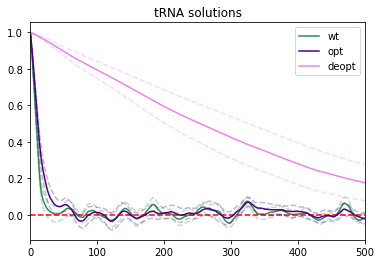

In [11]:
acov,err_acov = ia().get_autocov(trna_ssa_soln_wt.intensity_vec[:,1000:,:],norm='global')
acc,err_acorr = ia().get_autocorr(acov)



plt.plot(np.mean(acc[0],axis=1),color='seagreen');
plt.plot(np.mean(acc[0],axis=1) - err_acorr[0],'--',color='seagreen', label='_nolegend_',alpha=.3)
plt.plot(np.mean(acc[0],axis=1)+ err_acorr[0],'--',color='seagreen', label='_nolegend_',alpha=.3)
plt.plot([0,500],[0,0],'r--', label='_nolegend_')
plt.xlim([0,500])


acov,err_acov = ia().get_autocov(trna_ssa_soln_opt.intensity_vec[:,1000:,:],norm='global')
acc,err_acorr = ia().get_autocorr(acov)
plt.plot(np.mean(acc[0],axis=1),color='indigo');
plt.plot(np.mean(acc[0],axis=1) - err_acorr[0],'--',color='indigo', label='_nolegend_',alpha=.3)
plt.plot(np.mean(acc[0],axis=1)+ err_acorr[0],'--',color='indigo', label='_nolegend_',alpha=.3)

plt.xlim([0,500])



acov,err_acov = ia().get_autocov(trna_ssa_soln_deopt.intensity_vec[:,1000:,:],norm='global')
acc,err_acorr = ia().get_autocorr(acov)

plt.plot(np.mean(acc[0],axis=1),color='violet');
plt.plot(np.mean(acc[0],axis=1) - err_acorr[0],'--',color='violet', label='_nolegend_',alpha=.3)
plt.plot(np.mean(acc[0],axis=1)+ err_acorr[0],'--',color='violet', label='_nolegend_',alpha=.3)

plt.xlim([0,500])

plt.legend(['wt','opt','deopt',])
plt.title('tRNA solutions')

In [12]:
trna_ssa_soln_wt.__dict__.keys()

dict_keys(['n_traj', 'k', 'no_rib_per_mrna', 'rib_density', 'ribosome_means', 'rib_vec', 'intensity_vec', 'time_vec_fixed', '_SSA_Soln__meta', 'no_ribosomes', 'rib_means', 'time', 'time_rec', 'start_time', 'watched_ribs', 'solutions', 'all_trna_results', 'col_points'])

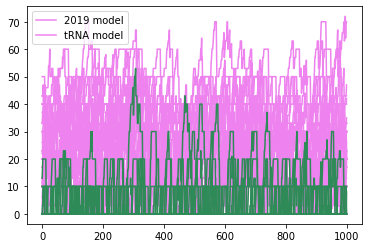

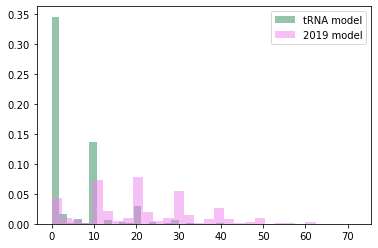

<Figure size 432x288 with 0 Axes>

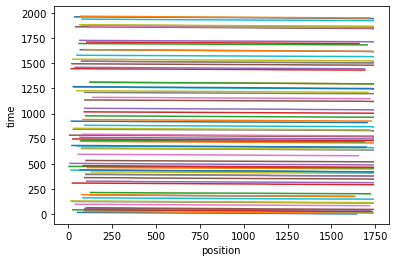

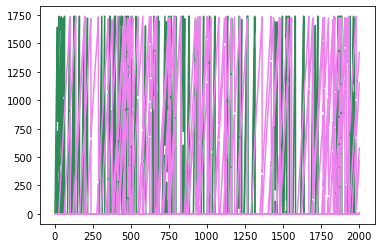

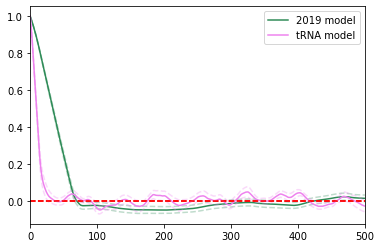

In [13]:
plt.figure()

plt.plot(ssa_soln_wt.intensity_vec[0,1000:,:], color='violet')
plt.plot(trna_ssa_soln_wt.intensity_vec[0,1000:,:], color='seagreen')
plt.legend(['2019 model','tRNA model'])

plt.figure()
num_bins = 30
n, bins, patches = plt.hist(trna_ssa_soln_wt.intensity_vec[:,1000:,:].flatten(), num_bins, facecolor='seagreen',density=True, alpha=0.5)
plt.hist(ssa_soln_wt.intensity_vec[:,1000:,:].flatten(),num_bins, facecolor='violet',density=True, alpha=0.5)
plt.legend(['tRNA model','2019 model'])


plt.figure()

ft, fa = fss().get_fragments(trna_ssa_soln_wt.solutions[0])

plt.figure()
for i in range(len(fa)): 
    
    frag = fa[i][fa[i] > 0]
    
    timeseg = t[ft[i]: ft[i] + len(frag) ]
    
    
    plt.plot(frag ,timeseg[::-1] )
    
plt.xlabel('position')
plt.ylabel('time')

plt.figure()
plt.plot(trna_ssa_soln_wt.solutions[0].T,'seagreen')
plt.plot(ssa_soln_wt.solutions[0].T,'violet')

plt.figure()

acov,err_acov = ia().get_autocov(ssa_soln_wt.intensity_vec,norm='global')
acc,err_acorr = ia().get_autocorr(acov)

plt.plot(np.mean(acc[0],axis=1),color='seagreen');
plt.plot(np.mean(acc[0],axis=1) - err_acorr[0],'--',color='seagreen', label='_nolegend_',alpha=.3)
plt.plot(np.mean(acc[0],axis=1)+ err_acorr[0],'--',color='seagreen', label='_nolegend_',alpha=.3)
plt.plot([0,500],[0,0],'r--', label='_nolegend_')
plt.xlim([0,500])

acov,err_acov = ia().get_autocov(trna_ssa_soln_wt.intensity_vec,norm='global')
acc,err_acorr = ia().get_autocorr(acov)

plt.plot(np.mean(acc[0],axis=1),color='violet');
plt.plot(np.mean(acc[0],axis=1) - err_acorr[0],'--',color='violet', label='_nolegend_',alpha=.3)
plt.plot(np.mean(acc[0],axis=1)+ err_acorr[0],'--',color='violet', label='_nolegend_',alpha=.3)
plt.plot([0,500],[0,0],'r--', label='_nolegend_')
plt.xlim([0,500])

plt.legend(['2019 model','tRNA model'])


(1000.0, 2000.0)

<Figure size 432x288 with 0 Axes>

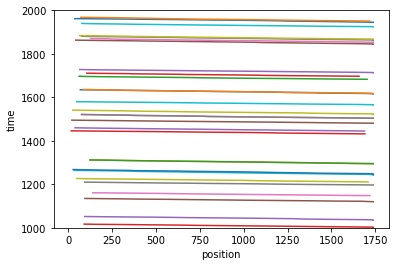

<Figure size 432x288 with 0 Axes>

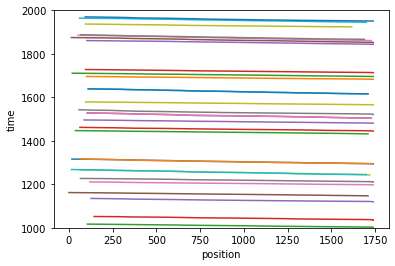

<Figure size 432x288 with 0 Axes>

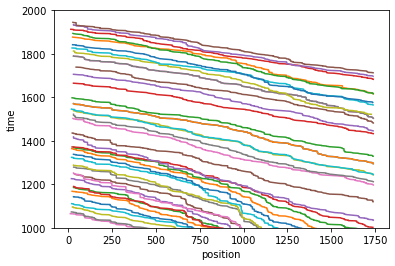

In [14]:


plt.figure()

ft, fa = fss().get_fragments(trna_ssa_soln_wt.solutions[0])

plt.figure()
for i in range(len(fa)): 
    
    frag = fa[i][fa[i] > 0]
    
    timeseg = t[ft[i]: ft[i] + len(frag) ]
    
    
    plt.plot(frag ,timeseg[::-1] )
    
plt.xlabel('position')
plt.ylabel('time')
plt.ylim([1000,2000])


plt.figure()

ft, fa = fss().get_fragments(trna_ssa_soln_opt.solutions[0])

plt.figure()
for i in range(len(fa)): 
    
    frag = fa[i][fa[i] > 0]
    
    timeseg = t[ft[i]: ft[i] + len(frag) ]
    
    
    plt.plot(frag ,timeseg[::-1] )
    
plt.xlabel('position')
plt.ylabel('time')
plt.ylim([1000,2000])

plt.figure()

ft, fa = fss().get_fragments(trna_ssa_soln_deopt.solutions[0])

plt.figure()
for i in range(len(fa)): 
    
    frag = fa[i][fa[i] > 0]
    
    timeseg = t[ft[i]: ft[i] + len(frag) ]
    
    
    plt.plot(frag ,timeseg[::-1] )
    
plt.xlabel('position')
plt.ylabel('time')
plt.ylim([1000,2000])

In [15]:
# Test case 

#Choose slow codon half as fast, alternate the two



In [16]:
#ind = -2
#plt.plot(trna_pool_traj[1000:1200,ind],'o',color='seagreen')
#plt.plot(trna_pool_traj_opt[1000:1200,ind],'o',color='indigo')
#plt.plot(trna_pool_traj_deopt[1000:1200,ind],'o',color='violet')

#plt.figure()
#plt.scatter(np.linspace(0,60,61).tolist(),np.mean(trna_pool_traj,axis=0),color='seagreen')
#plt.scatter(np.linspace(0,60,61).tolist(),np.mean(trna_pool_traj_opt,axis=0),color='indigo')
#plt.scatter(np.linspace(0,60,61).tolist(),np.mean(trna_pool_traj_deopt,axis=0),color='violet')

NameError: name 'trna_pool_traj' is not defined

In [17]:
trna_inv = dict(map(reversed, cdict().trna_dict.items()))
alldict = cdict().strGeneCopy



wtmean = np.sum(1/ np.array([  alldict[  trna_inv[i]] for i in huminsr.ktrna_id] ))
print('Wt analytical tau: ')
print(wtmean)
fastmean =  np.sum(1/ np.array([  alldict[  trna_inv[i]] for i in huminsr_opt.ktrna_id] ))
print('opt analytical tau: ')
print(fastmean)
slowmean =  np.sum(1/ np.array([  alldict[  trna_inv[i]] for i in huminsr_deopt.ktrna_id] ))
print('deopt analytical tau: ')
print(slowmean)



Wt analytical tau: 
104.3790677699201
opt analytical tau: 
79.77723543728395
deopt analytical tau: 
191.70165616650405


In [19]:
#traj = all_results_opt[0,:].reshape((N_rib,len(t_array))).T
#plt.plot(traj[1000:1500],color='indigo')


#traj = all_results[0,:].reshape((N_rib,len(t_array))).T
#plt.plot(traj[1000:1500],color='seagreen')


#traj = all_results_deopt[0,:].reshape((N_rib,len(t_array))).T
#plt.plot(traj[1000:1500],color='violet')
#pass


In [31]:
(tid,counts) = np.unique(poi.ktrna_id, return_counts=True)
print(tid)
print(counts)

from rss import CodonDictionaries as cd



trna_inv = dict(map(reversed, cd().trna_dict.items()))

slow_codon = trna_inv[np.where(counts==1)[0][0]]
ind = np.where(counts==1)[0][0]
poi.codons.count(slow_codon)
poi.codons.index(slow_codon)
trna_inv[ind]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60]
[21 22 24 18 51 30 43 32  3 21 17 16 22  8 18 10  5 37 41 35 20  6 16 10
 14 77 23 42 29 25 16 23 17 47 47 58 12  1  5 32 10 44 18 71 20  8 13 53
 21 35 33 77 48  2 12 39 44 62 20 83 32]


'AUA'

In [21]:
wt_trna = [i for i, x in enumerate(poi.codons) if x == slow_codon]

spread_trna = [400,500,600,800,900,1200,1600]

close_trna = [1200,1215,1230,1245,1260,1275,1290]
closest_trna = [1200,1201,1202,1203,1204,1205,1206]

k_index = np.array(poi.ktrna_id)

k_spread = np.copy(k_index)
k_spread[418] = 10
k_spread[spread_trna] = ind

k_close = np.copy(k_index)
k_close[418] = 10
k_close[close_trna] = ind

k_closest= np.copy(k_index)
k_closest[418] = 10
k_closest[closest_trna] = ind

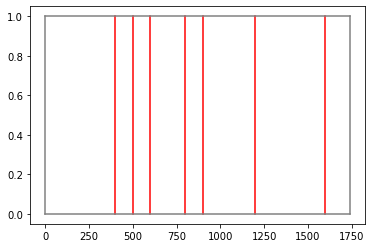

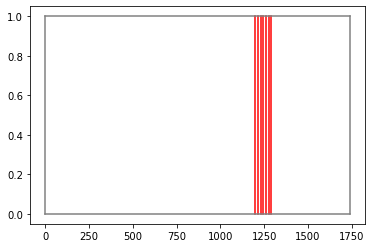

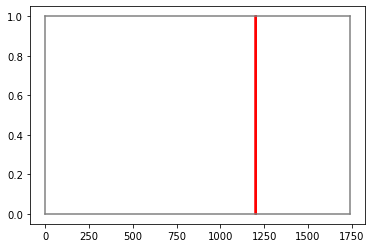

In [22]:
for i in range(len(spread_trna)):
    plt.plot([spread_trna[i],spread_trna[i] ],[0,1],'r' )

plt.plot([0,0 ],[0,1],'gray' )
plt.plot([len(poi.kelong),len(poi.kelong) ],[0,1],'gray' )
plt.plot([0,len(poi.kelong) ],[1,1],'gray' )
plt.plot([0,len(poi.kelong) ],[0,0],'gray' )

plt.figure()


for i in range(len(close_trna)):
    plt.plot([close_trna[i],close_trna[i] ],[0,1],'r' )

plt.plot([0,0 ],[0,1],'gray' )
plt.plot([len(poi.kelong),len(poi.kelong) ],[0,1],'gray' )
plt.plot([0,len(poi.kelong) ],[1,1],'gray' )
plt.plot([0,len(poi.kelong) ],[0,0],'gray' )

plt.figure()

for i in range(len(closest_trna)):
    plt.plot([closest_trna[i],closest_trna[i] ],[0,1],'r' )

plt.plot([0,0 ],[0,1],'gray' )
plt.plot([len(poi.kelong),len(poi.kelong) ],[0,1],'gray' )
plt.plot([0,len(poi.kelong) ],[1,1],'gray' )
plt.plot([0,len(poi.kelong) ],[0,0],'gray' )

In [40]:
strGeneCopy = {'TTT': 17.6, 'TCT': 15.2, 'TAT': 12.2, 'TGT': 10.6, 'TTC': 20.3,
                            'TCC': 17.7, 'TAC': 15.3, 'TGC': 12.6, 'TTA': 7.7, 'TCA': 12.2,
                            'TAA': 1.0, 'TGA': 1.6, 'TTG': 12.9, 'TCG':  4.4, 'TAG': 0.8,
                            'TGG': 13.2, 'CTT': 13.2, 'CCT': 17.5, 'CAT': 10.9, 'CGT': 4.5,
                            'CTC': 19.6, 'CCC': 19.8, 'CAC': 15.1, 'CGC': 10.4, 'CTA':  7.2,
                            'CCA': 16.9, 'CAA': 12.3, 'CGA':  6.2, 'CTG': 39.6, 'CCG':  6.9,
                            'CAG': 34.2, 'CGG': 11.4, 'ATT': 16.0, 'ACT': 13.1, 'AAT': 17.0,
                            'AGT': 12.1, 'ATC': 20.8, 'ACC': 18.9, 'AAC': 19.1, 'AGC': 19.5,
                            'ATA':  7.5, 'ACA': 15.1, 'AAA': 24.4, 'AGA': 12.2, 'ATG': 22.0,
                            'ACG': 6.1, 'AAG': 31.9, 'AGG': 12.0, 'GTT': 11.0, 'GCT': 18.4,
                            'GAT': 21.8, 'GGT': 10.8, 'GTC': 14.5, 'GCC': 27.7, 'GAC': 25.1,
                            'GGC': 22.2, 'GTA':  7.1, 'GCA': 15.8, 'GAA': 29.0, 'GGA': 16.5,
                            'GTG': 28.1, 'GCG': 7.4, 'GAG': 39.6, 'GGG': 16.5}


strGeneCopy.pop('TAG')
strGeneCopy.pop('TAA')
strGeneCopy.pop('TGA')

k_trna = np.array(list(strGeneCopy.values()))

k_trna[ind] = k_trna[ind]*.05 # Deplete AUA by 95%

t = np.linspace(0,4000,4001)
k_diffusion = 1
k_bind = .033
elong_scale = 1

trna_ssa_soln_spread = wt_solver.solve_ssa_trna( k_spread , k_diffusion,k_bind,elong_scale ,t,n_traj=1,k_trna= k_trna)

trna_ssa_soln_close = opt_solver.solve_ssa_trna(k_close, k_diffusion,k_bind,elong_scale ,t,n_traj=1,k_trna= k_trna)

trna_ssa_soln_closest = deopt_solver.solve_ssa_trna(k_closest, k_diffusion,k_bind,elong_scale ,t,n_traj=1,k_trna= k_trna)


C:\Users\willi\Anaconda2\envs\newpy36clone\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\willi\Anaconda2\envs\newpy36clone\lib\site-packages\numpy\core\_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\willi\Anaconda2\envs\newpy36clone\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\willi\Anaconda2\envs\newpy36clone\lib\site-packages\numpy\core\_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\willi\Anaconda2\envs\newpy36clone\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\willi\Anaconda2\envs\newpy36clone\lib\site-packages\numpy\core\_methods.py:207: RuntimeWarning: invalid value

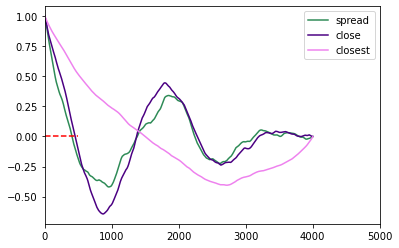

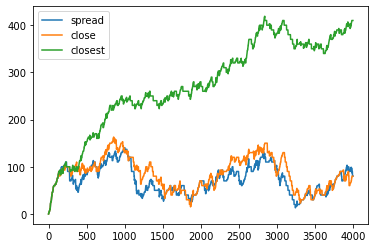

In [41]:
acov,err_acov = ia().get_autocov(trna_ssa_soln_spread.intensity_vec,norm='global')
acc,err_acorr = ia().get_autocorr(acov)


plt.plot(np.mean(acc[0],axis=1),color='seagreen');
plt.plot(np.mean(acc[0],axis=1) - err_acorr[0],'--',color='seagreen', label='_nolegend_',alpha=.3)
plt.plot(np.mean(acc[0],axis=1)+ err_acorr[0],'--',color='seagreen', label='_nolegend_',alpha=.3)

acov,err_acov = ia().get_autocov(trna_ssa_soln_close.intensity_vec,norm='global')
acc,err_acorr = ia().get_autocorr(acov)


plt.plot(np.mean(acc[0],axis=1),color='indigo');
plt.plot(np.mean(acc[0],axis=1) - err_acorr[0],'--',color='indigo', label='_nolegend_',alpha=.3)
plt.plot(np.mean(acc[0],axis=1)+ err_acorr[0],'--',color='indigo', label='_nolegend_',alpha=.3)

acov,err_acov = ia().get_autocov(trna_ssa_soln_closest.intensity_vec,norm='global')
acc,err_acorr = ia().get_autocorr(acov)


plt.plot(np.mean(acc[0],axis=1),color='violet');
plt.plot(np.mean(acc[0],axis=1) - err_acorr[0],'--',color='violet', label='_nolegend_',alpha=.3)
plt.plot(np.mean(acc[0],axis=1)+ err_acorr[0],'--',color='violet', label='_nolegend_',alpha=.3)


plt.plot([0,500],[0,0],'r--', label='_nolegend_')


plt.xlim([0,5000])

plt.legend(['spread','close','closest',])


plt.figure()
plt.plot(trna_ssa_soln_spread.intensity_vec[0,:,0] )
plt.plot(trna_ssa_soln_close.intensity_vec[0,:,0])
plt.plot(trna_ssa_soln_closest.intensity_vec[0,:,0])
plt.legend(['spread','close','closest',])

#plt.figure()
#plt.plot(trna_pool_traj_spread[:,ind])
#plt.plot(trna_pool_traj_close[:,ind])
#plt.plot(trna_pool_traj_closest[:,ind])

#np.where(k_index == ind)

Text(0, 0.5, 'time')

<Figure size 432x288 with 0 Axes>

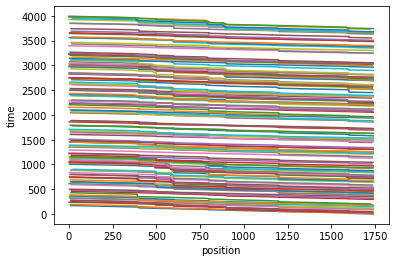

<Figure size 432x288 with 0 Axes>

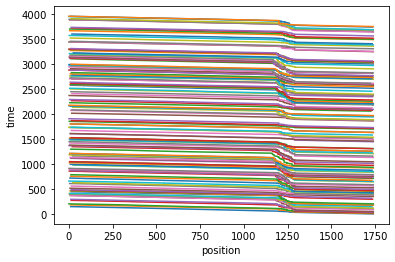

<Figure size 432x288 with 0 Axes>

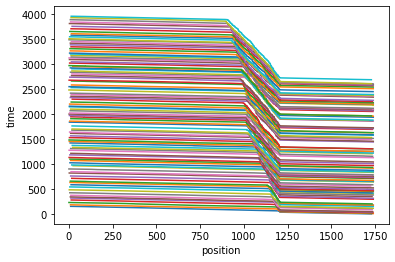

In [43]:

plt.figure()

ft, fa = fss().get_fragments(trna_ssa_soln_spread.solutions[0])

plt.figure()
for i in range(len(fa)): 
    
    frag = fa[i][fa[i] > 0]
    
    timeseg = t[ft[i]: ft[i] + len(frag) ]
    
    
    plt.plot(frag ,timeseg[::-1] )
    
plt.xlabel('position')
plt.ylabel('time')



plt.figure()

ft, fa = fss().get_fragments(trna_ssa_soln_close.solutions[0])

plt.figure()
for i in range(len(fa)): 
    
    frag = fa[i][fa[i] > 0]
    
    timeseg = t[ft[i]: ft[i] + len(frag) ]
    
    
    plt.plot(frag ,timeseg[::-1] )
    
plt.xlabel('position')
plt.ylabel('time')


plt.figure()

ft, fa = fss().get_fragments(trna_ssa_soln_closest.solutions[0])

plt.figure()
for i in range(len(fa)): 
    
    frag = fa[i][fa[i] > 0]
    
    timeseg = t[ft[i]: ft[i] + len(frag) ]
    
    
    plt.plot(frag ,timeseg[::-1] )
    
plt.xlabel('position')
plt.ylabel('time')


In [38]:
timeseg[::-1]

array([1928., 1927., 1926., ...,  352.,  351.,  350.])

In [ ]:
k = np.array(huminsr.kelong)

spread_trna = [400,500,600,800,900,1200,1600]

k[spread_trna] = k[418]
k[418] = 16.3*(strGeneCopy['TTG']/np.mean(list(strGeneCopy.values())))


wt_solver = tss()  #solver class
wt_solver.protein=huminsr
wt_solver.default_conditions['burnin'] = 1000

ssa_soln_spread = wt_solver.solve_ssa([.033] + k.tolist()  + [10],t,n_traj=150)

#############################

k = np.array(huminsr.kelong)

k[close_trna] = k[418]
k[418] = 16.3*(strGeneCopy['TTG']/np.mean(list(strGeneCopy.values())))


wt_solver = tss()  #solver class
wt_solver.protein=huminsr
wt_solver.default_conditions['burnin'] = 1000

ssa_soln_close = wt_solver.solve_ssa([.033] + k.tolist() + [10],t,n_traj=150)

############################


k = np.array(huminsr.kelong)

k[closest_trna] = k[418]
k[418] = 16.3*(strGeneCopy['TTG']/np.mean(list(strGeneCopy.values())))

wt_solver = tss()  #solver class
wt_solver.protein=huminsr
wt_solver.default_conditions['burnin'] = 1000

ssa_soln_closest = wt_solver.solve_ssa([.033] + k.tolist()  + [10],t,n_traj=150)

############################

In [ ]:
acov,err_acov = ia().get_autocov(ssa_soln_spread.intensity_vec,norm='global')
acc,err_acorr = ia().get_autocorr(acov)



plt.plot(np.mean(acc[0],axis=1),color='seagreen');
plt.plot(np.mean(acc[0],axis=1) - err_acorr[0],'--',color='seagreen', label='_nolegend_',alpha=.3)
plt.plot(np.mean(acc[0],axis=1)+ err_acorr[0],'--',color='seagreen', label='_nolegend_',alpha=.3)
plt.plot([0,500],[0,0],'r--', label='_nolegend_')
plt.xlim([0,500])


acov,err_acov = ia().get_autocov(ssa_soln_close.intensity_vec,norm='global')
acc,err_acorr = ia().get_autocorr(acov)
plt.plot(np.mean(acc[0],axis=1),color='indigo');
plt.plot(np.mean(acc[0],axis=1) - err_acorr[0],'--',color='indigo', label='_nolegend_',alpha=.3)
plt.plot(np.mean(acc[0],axis=1)+ err_acorr[0],'--',color='indigo', label='_nolegend_',alpha=.3)

plt.xlim([0,500])



acov,err_acov = ia().get_autocov(ssa_soln_closest.intensity_vec,norm='global')
acc,err_acorr = ia().get_autocorr(acov)

plt.plot(np.mean(acc[0],axis=1),color='violet');
plt.plot(np.mean(acc[0],axis=1) - err_acorr[0],'--',color='violet', label='_nolegend_',alpha=.3)
plt.plot(np.mean(acc[0],axis=1)+ err_acorr[0],'--',color='violet', label='_nolegend_',alpha=.3)

plt.xlim([0,500])

plt.legend(['spread','close','closest',])

plt.figure()
plt.plot(np.mean(ssa_soln_spread.intensity_vec,axis=2)[0]  )
plt.plot(np.mean(ssa_soln_close.intensity_vec,axis=2)[0])
plt.plot(np.mean(ssa_soln_closest.intensity_vec,axis=2)[0] )
plt.legend(['spread','close','closest',])

In [ ]:
np.mean(ssa_soln_spread.intensity_vec,axis=2)

In [ ]:
plt.plot(trna_pool_traj[:,ind])
np.where(k_index == ind)

In [ ]:
cd().trna_ids_vals


In [ ]:
cd().trna_ids[11]

In [ ]:
ind

In [ ]:
#harringtonine comparison of 2019 model + tRNA model